# S2_Project_박태준 - 익일 주가지수 등락 예측

In [2]:
# major lib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# data tool
from sklearn.model_selection import train_test_split
from pandas_profiling import ProfileReport
from ipywidgets import interact

# Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer

# feature engineering lib
from sklearn.feature_selection import SelectKBest

# encoder lib
from category_encoders import OneHotEncoder
from category_encoders import OrdinalEncoder

# imputer lib
from sklearn.impute import SimpleImputer # Simple Imputation (Mean, Median, Mode)
# from impyute.imputation.cs import mice # Multiple Imputation (MI)

# model engine lib
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# evaluation lib
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix

# etc lib
from ipywidgets import interact, fixed
from tqdm.notebook import tqdm, trange
import warnings
warnings.filterwarnings('ignore')

## Part.1 데이터 수집과 가설설정

<환율> 

환율은 주가예측의 가장 기본이 되는 자료입니다. 
환율이 높다면 국내투자자금이 외화로 환전 되어 자본 유출이 일어나 주식시장의 하락신호로 해석될 수 있으며, 
반대로 수출기업들이 높은 환율로 높은 영업이익을 달성할 수 주식시장의 상승신호로도 해석될 수 있기 때문입니다. 

<국제유가> 

우리나라는 제조업 수출기업 중심국가로 이 기업들에게 가장 중요한 원자재는 원유입니다. 
유가가 변동폭이 적은 경우 수출기업들이 안정적인 영업이익을 달성할 수 있습니다.

<전월수출실적>

코스피는 제조업 수출기업들이 다수를 차지합니다.
전월 수출실적이 나쁜 경우 다음날 코스피가 하락할 확률이 높다는 가설을 세워 데이터에 편입시켰습니다.

<전월통화량>

통화량이 감소한다면 현금의 가치가 상승한다는 뜻으로 해석됩니다.
투자자들은 현금의 상승하기 때문에 주식사장과 같은 자본시장에 투자하는 비중이 낮아질 것이며
자연스럽게 매도 우위로 인한 주가하락이 예상될 수 있습니다.

<시장예탁금> <주식계좌개설수>

미국 케네디 대통령의 아버지인 조세프 케네디는 월가에서 막대한 부를 쌓은 금융인입니다.
그가 대공황이 오기 직전, 구두닦이 소년이 자신에게 주식을 이야기하는 것을 보고
서둘러 주식을 전부 팔아 손실을 피한 일화는 유명합니다. 

어린 소년까지 주식을 사고파는 이야기를 할 정도면 주식시장이 과열되었다는 뜻이며,
다시 말해 더 이상 주식을 살 사람이 없으며 사는 사람이 없으니 떨어질 일만 남은 것으로 해석되기 때문입니다.
저는 이러한 논리를 믿는 사람으로써 주식시장이 과열되는지 여부를
투자자들이 주식계좌에 예치하는 금액의 증감률과 주식계좌개설건수의 증가율로 파악해보기 위해 데이터를 활용해볼 것 입니다.

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/laprass/drive/main/source_edit.csv')

## Part.2 EDA & Target

< EDA >

전처리, EDA, FE 과정은 단순하게 처리하였습니다.

(1) 모든 데이터들은 전일 대비 등락률로 변경

(2) 결측치는 각 특성의 바로 전일의 데이터로 대체

(3) 타겟이 되는 코스피 지수는 상승과 보합장은 0, 하락장은 1이라는 이진분류로 변경


< Feature Enginerring >

모든 특성 값을 전일(전월) 대비의 등락률로 변경


< Target >

코스피지수의 전일대비 등락률을 이진분류로 변환

전일대비 하락했을 경우 (1)

그 외의 경우는 (0)

In [4]:
# 테스트 데이터 (20%)
train, test = train_test_split(df, test_size = 0.2, random_state = 2)

In [5]:
# 검증 데이터 (20%)
train, val = train_test_split(train, test_size = 0.2, random_state = 5)

In [6]:
features = train.drop(columns = ['kospi','target','date','trade']).columns
target = 'target'

x_train = train[features]
y_train = train[target]
x_val = val[features]
y_val = val[target]
x_test = test[features]
y_test = test[target]

print(f'X_Train size = {x_train.shape} / y_Train size = {len(y_train)}\n')
print(f'X_Val size = {x_val.shape} / y_Val size = {len(y_val)}\n')
print(f'X_Test size  = {x_test.shape} / y_Test size = {len(y_test)}\n')

X_Train size = (2470, 7) / y_Train size = 2470

X_Val size = (618, 7) / y_Val size = 618

X_Test size  = (773, 7) / y_Test size = 773



In [7]:
# 훈련 데이터셋
x_train

,fund,acc,usd,wti,lf,export,import
2004,0.0628,0.0004,0.0020,-0.0142,0.007834,-0.059211,-0.058166
3248,-0.0249,0.0003,0.0064,-0.0262,0.003357,-0.061931,-0.035052
2548,-0.0286,0.0004,-0.0079,0.0660,0.011501,0.197772,0.140411
1327,0.0102,-0.0004,0.0034,-0.0577,0.010374,0.049251,-0.011161
3468,-0.0382,0.0003,-0.0001,-0.0028,0.004835,0.013636,-0.089412
...,...,...,...,...,...,...,...
3503,-0.0409,0.0003,-0.0023,0.0132,0.007280,-0.055794,-0.016908
3526,-0.0046,0.0003,-0.0050,-0.0493,0.003749,0.038636,0.073710
924,0.0148,0.0011,0.0010,NaN,0.003835,0.058824,0.115254
1201,0.0244,0.0006,0.0088,-0.0026,0.010265,0.006787,0.047382


In [8]:
# 기준모델과 정확도
major = y_train.mode()[0]
base_pred = [major] * len(y_train)
base_acc_score = accuracy_score(y_train, base_pred)

print(f'Baseline Model_Accuracy = {base_acc_score:.4f}')

Baseline Model_Accuracy = 0.5036


## Part.3 Modeling

In [9]:
# 1차 모델링

from lightgbm import LGBMClassifier

first_model = LGBMClassifier(boosting_type = 'dart',
                       importance_type = 0,
                       n_estimators = 100,
                       max_depth = 5,
                       objective = 'regression',
                       learning_rate = 0.1,
                       random_state = 10,
                       n_jobs = -1)

first_model.fit(x_train, y_train)

LGBMClassifier(boosting_type='dart', importance_type=0, max_depth=5,
               objective='regression', random_state=10)

In [10]:
first_val_pred = first_model.predict(x_val)
print(f'Predict Model Accuracy = {accuracy_score(y_val, first_val_pred):.4f}')
print(f'F_Beta_Score = {f1_score(y_val, first_val_pred):.4f}')

Predict Model Accuracy = 0.6440
F_Beta_Score = 0.5618


## Part.4 Cross_Validation

In [11]:
# 교차검증

from sklearn.model_selection import cross_val_score

k = 10
scores = cross_val_score(first_model, x_train, y_train, cv=k, scoring='accuracy')

print(f'MAE ({k} folds):', scores.mean())

MAE (10 folds): 0.6182186234817814


## Part.5 Optimize Hyper_Prameter

In [12]:
# 파라미터 값 범위 지정

from sklearn.model_selection import GridSearchCV

param_gird = {'boosting_type': ['gbdt','dart'],
              'max_depth' : [5,8,10,15,20],
              'n_estimators' : [10,20,30,40,50,60,70,80,90,100,150,200]}

In [274]:
# GridSearchCV로 최적 파라미터 찾기

clf = GridSearchCV(first_model, param_gird, cv = 5)

clf.fit(x_train, y_train);

print('최적 하이퍼파라미터: ', clf.best_params_)
print('최적 정확도: ', -clf.best_score_)

최적 하이퍼파라미터:  {'boosting_type': 'gbdt', 'max_depth': 5, 'n_estimators': 30}
최적 정확도:  -0.6331983805668016


In [276]:
# 2차 모델링 (파라미터 최적화 반영)

from lightgbm import LGBMClassifier

second_model = LGBMClassifier(boosting_type = 'gbdt',
                       importance_type = 0,
                       n_estimators = 30,
                       max_depth = 5,
                       objective = 'regression',
                       learning_rate = 0.1,
                       random_state = 10,
                       n_jobs = -1)

second_model.fit(x_train, y_train)

LGBMClassifier(importance_type=0, max_depth=5, n_estimators=30,
               objective='regression', random_state=10)

In [277]:
second_val_pred = second_model.predict(x_val)
print(f'Predict Model Accuracy = {accuracy_score(y_val, second_val_pred):.4f}')
print(f'F_Beta_Score = {f1_score(y_val,second_val_pred):.4f}')

Predict Model Accuracy = 0.6472
F_Beta_Score = 0.6267


## Part.6 Set Threshold 

In [296]:
# 임계값 설정
val_pred_proba = second_model.predict_proba(x_val)[:,1]
threshold = 0.459
y_val_pred_proba = val_pred_proba > threshold

print(f'Predict Model Accuracy = {accuracy_score(y_val, y_val_pred_proba):.4f}')
print(f'F_Beta_Score = {f1_score(y_val,y_val_pred_proba):.4f}')

Predict Model Accuracy = 0.6408
F_Beta_Score = 0.6509


## Part.7 Final Model

In [297]:
test_pred_proba = second_model.predict_proba(x_test)[:,1]
y_test_pred_proba = test_pred_proba > threshold

print(f'Predict Model Accuracy = {accuracy_score(y_test, y_test_pred_proba):.4f}')
print(f'F_Beta_Score = {f1_score(y_test,y_test_pred_proba):.4f}')

Predict Model Accuracy = 0.6132
F_Beta_Score = 0.6142


## Part.8 Permutation_Importance

In [298]:
# 순열중요도를 감안한 modeling

import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(model, scoring = 'accuracy', n_iter = 5, random_state = 2)
permuter.fit(x_val,y_val);

In [299]:
feature_names = x_val.columns.tolist()
importance = pd.Series(permuter.feature_importances_, feature_names).sort_values()
importance

export   -0.010032
import   -0.009061
lf       -0.003560
acc       0.009385
wti       0.010356
fund      0.041424
usd       0.103236
dtype: float64

In [300]:
minimum_importance = 0
mask = permuter.feature_importances_ > minimum_importance
mask_features = x_train.columns[mask]

x_train_selected = x_train[mask_features]
x_val_selected = x_val[mask_features]
x_test_selected = x_test[mask_features]

In [303]:
model_selected = LGBMClassifier(boosting_type = 'gbdt',
                                importance_type = 0,
                                n_estimators = 30,
                                max_depth = 5,
                                objective = 'regression',
                                learning_rate = 0.1,
                                random_state = 10,
                                n_jobs = -1)

model_selected.fit(x_train_selected, y_train)

selected_val_pred = model_selected.predict(x_val_selected)
print(f'Predict Model Accuracy = {accuracy_score(y_val, selected_val_pred):.4f}')
print(f'F_Beta_Score = {f1_score(y_val,selected_val_pred):.4f}')

Predict Model Accuracy = 0.6359
F_Beta_Score = 0.6218


In [305]:
clf_selected = GridSearchCV(model_selected, param_gird, cv = 5)

clf_selected.fit(x_train_selected, y_train)

print('최적 하이퍼파라미터: ', clf_selected.best_params_)
print('MAE: ', -clf_selected.best_score_)

최적 하이퍼파라미터:  {'boosting_type': 'gbdt', 'max_depth': 5, 'n_estimators': 10}
MAE:  -0.6360323886639676


## Part.9 Model_Analisys

In [319]:
# 하락예측

import shap
shap.initjs();

down = x_test.iloc[[10]]
y_test.iloc[[10]]

explainer = shap.TreeExplainer(second_model)
shap_down = explainer.shap_values(down)

shap.force_plot(base_value = explainer.expected_value,
                shap_values = shap_down,
                features = down)

하락을 예측할 경우 통화량(lf)과 환율(usd) 특성이 예측률을 높히는 요인이며

나머지 4개 특성은 주가하락 예측력을 감소시키는 요인으로 파악됩니다.

처음에 세운 가설인 주식계좌개설건수와 주식계좌예탁금의 변동률은 주가하락을 예측하는데 있어

적합한 특성이 아니었다는 것을 알 수 있습니다.

In [320]:
# 상승+보합 예측

up = x_test.iloc[[180]]
y_test.iloc[[180]]

shap_up = explainer.shap_values(up)

shap.force_plot(base_value = explainer.expected_value,
                shap_values = shap_up,
                features = up)

하락 외의 경우를 예측하는데 있어 유가(wti)와 주식계좌예탁금(fund)이 많이 반영되었음을 알 수 있습니다.

상반된 예측에 따라 정확도를 높히는 특성 값이 달라진다는 것을 알 수 있습니다.

하락하지 않는 경우에서 주식계좌예탁금 특성이 정확도를 높히는 요인으로 나타난 것을 보아

주식계좌 예탁금의 변동률은 하락 보다는 상승, 보합장에 적합한 특성이라 판단됩니다.

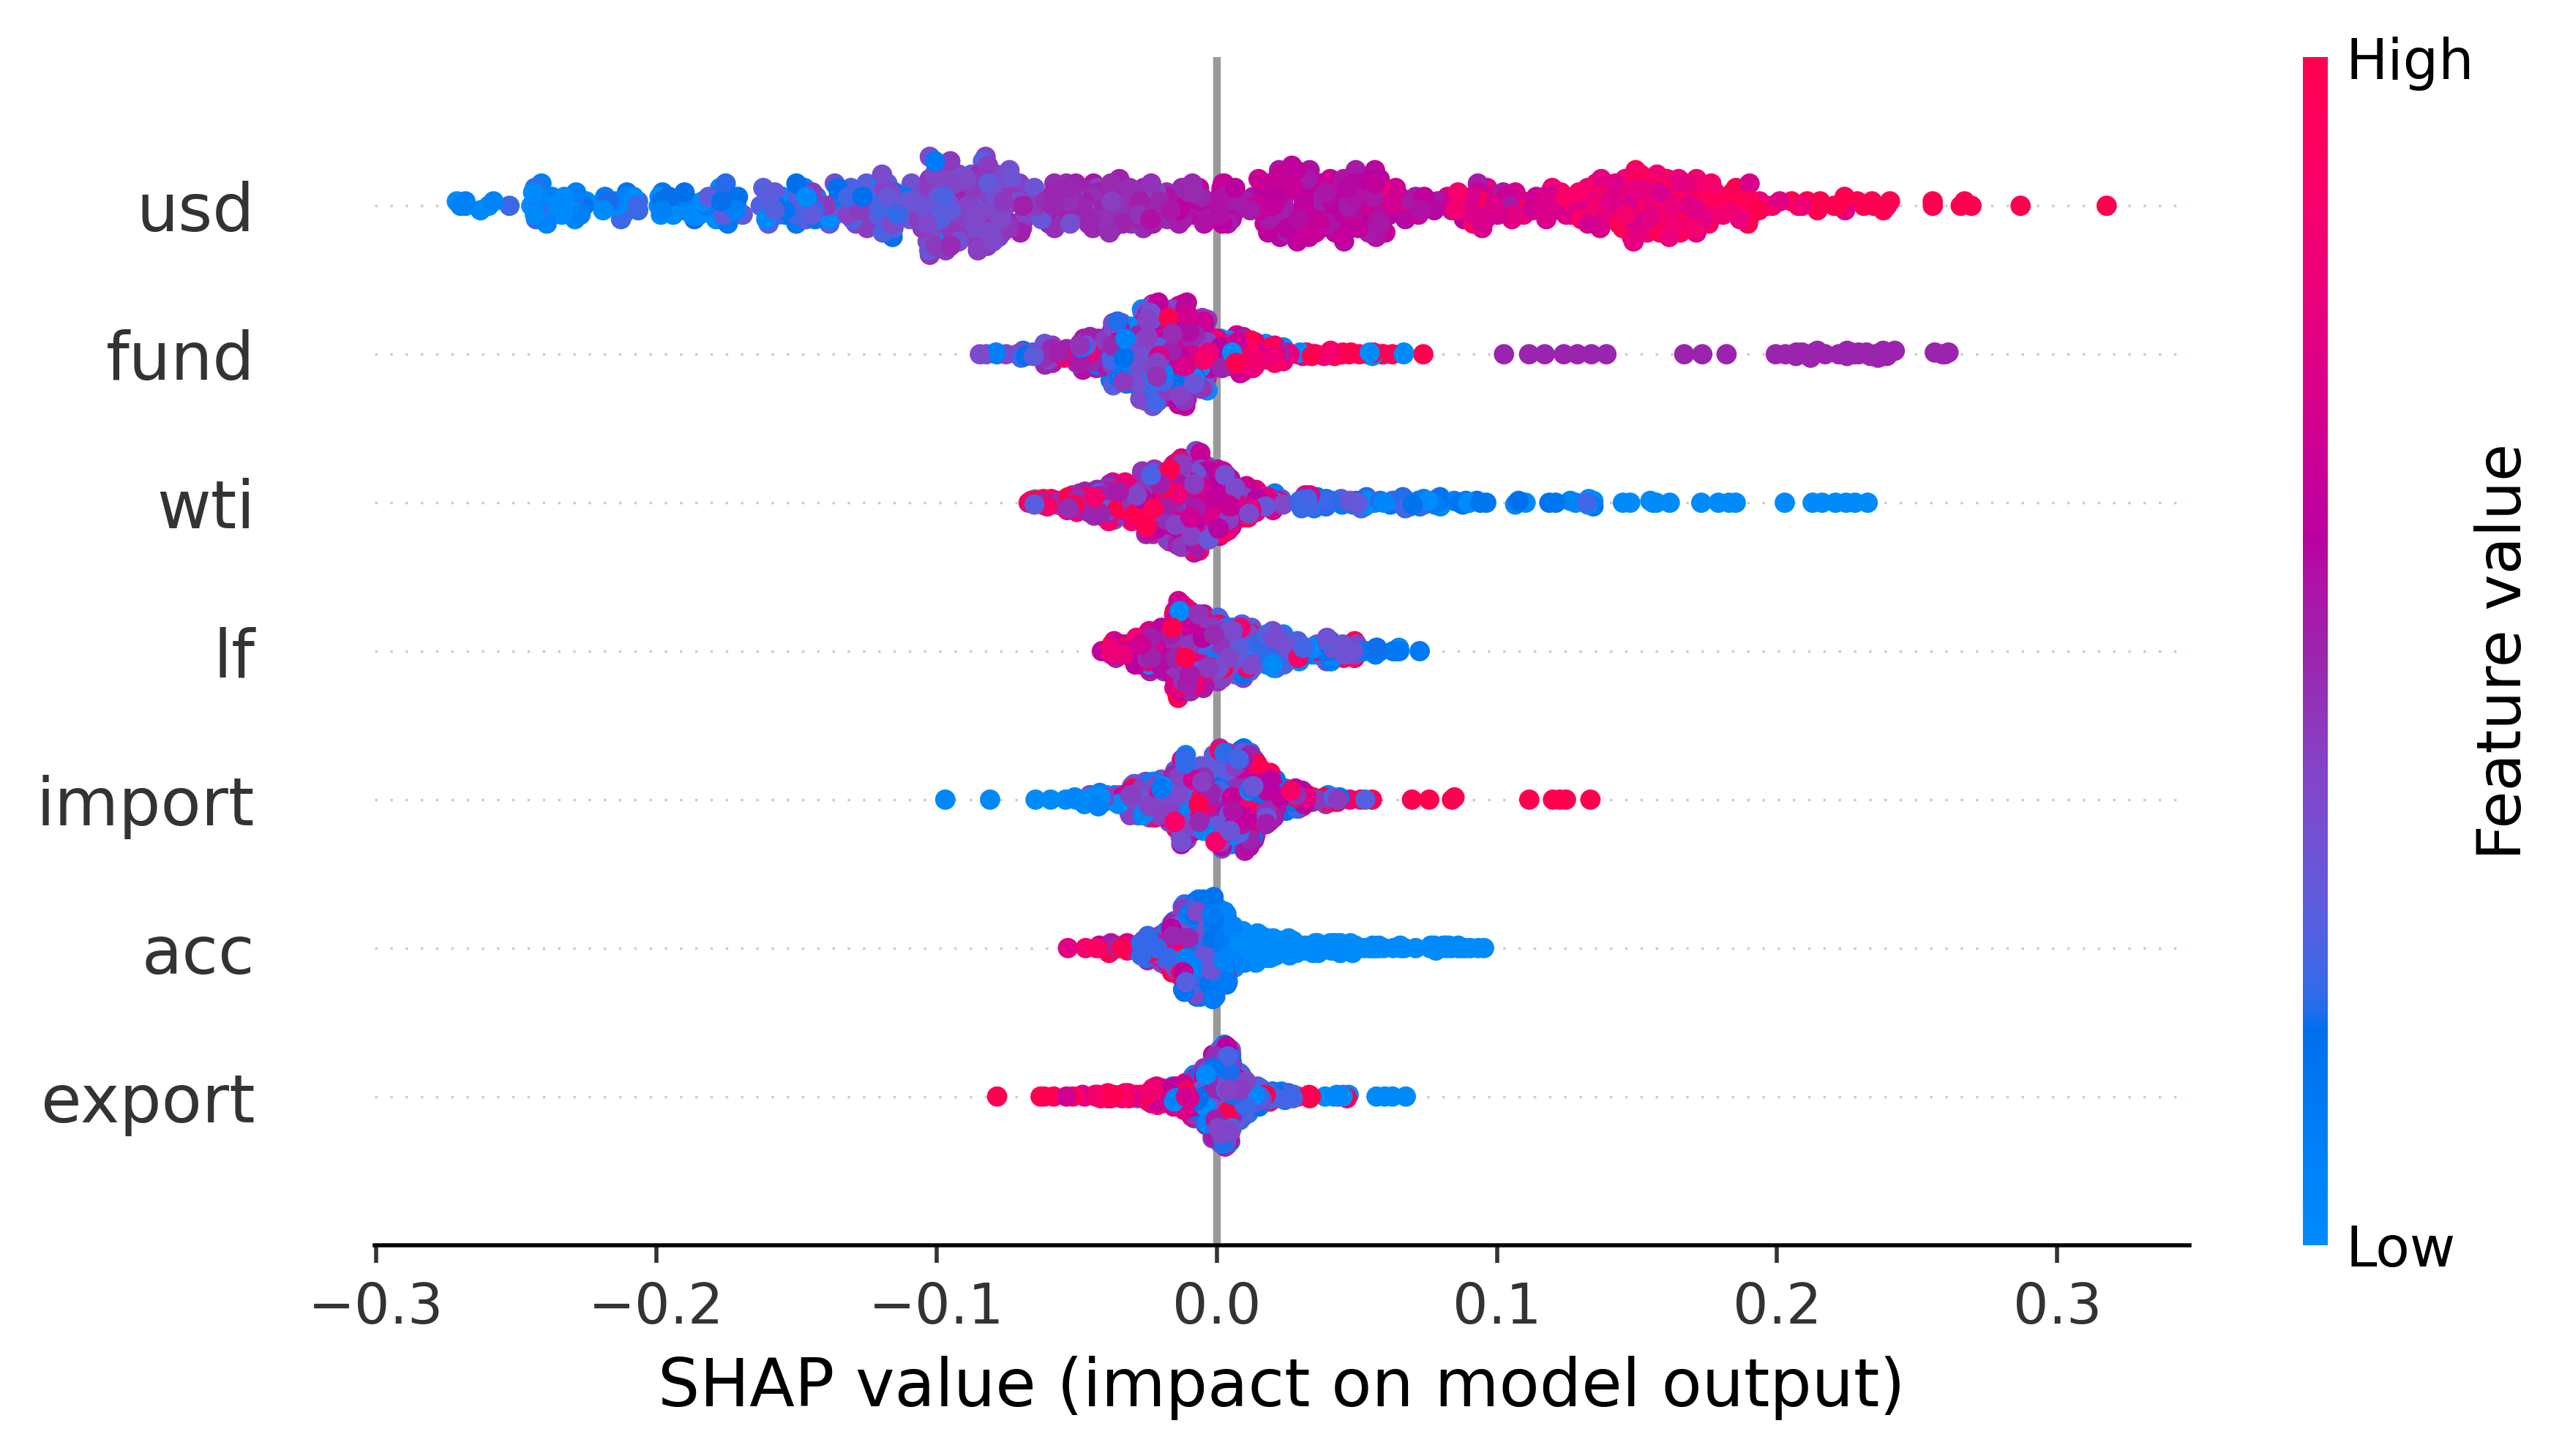

In [321]:
shap_test = explainer.shap_values(x_test)
shap.summary_plot(shap_test, x_test)

환율이 주가예측에 가장 큰 영향력을 갖는 것을 확인 할 수 있습니다.